In [1]:
# import the required packages
import random
import collections
import math
import os
import zipfile
import time
import re

import numpy as np
import tensorflow as tf

from matplotlib import pylab
%matplotlib inline

from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.contrib.tensorboard.plugins import projector
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Make sure the datadset link is copied correctly
dataset_link = 'http://mattmahoney.net/dc/'
zip_file = 'text8.zip'

def data_download(zip_file):
    """Download the required file"""
    if not os.path.exists(zip_file):
        zip_file,_ = urlretrieve(dataset_link + zip_file,zip_file)
        print("File download successfully")
    return None

data_download(zip_file) 

In [3]:
# Extracting the dataset in separate folder
extracted_folder = 'dataset'

if not os.path.isdir(extracted_folder):
    with zipfile.ZipFile(zip_file) as zf:
        zf.extractall(extracted_folder) 

In [4]:
with open('dataset/text8') as ft_:
    full_text = ft_.read() 

In [5]:
def text_processing(ft8_text):
    """Replacing punctuation marks with tokens"""
    ft8_text = ft8_text.lower()
    ft8_text = ft8_text.replace('.',' <period> ')
    ft8_text = ft8_text.replace(',',' <comma> ')
    ft8_text = ft8_text.replace('"',' <quotation> ')
    ft8_text = ft8_text.replace(';',' <semicolon> ')
    ft8_text = ft8_text.replace('!',' <exclamation> ')
    ft8_text = ft8_text.replace('?',' <question> ')
    ft8_text = ft8_text.replace('(',' <paren_l> ')
    ft8_text = ft8_text.replace(')',' <paren_r> ')
    ft8_text = ft8_text.replace('--',' <hyphen> ')
    ft8_text = ft8_text.replace(':',' <colon> ')
    ft8_text_tokens = ft8_text.split()
    
    return ft8_text_tokens

In [6]:
ft_tokens = text_processing(full_text)
"""Shortlisting words with frequency more than 7"""
word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > 7] 

In [7]:
print(shortlisted_words[:15]) 

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']


In [8]:
print("Total number of shortlisted words : ",len(shortlisted_words))
print("Unique number of shortlisted words : ",len(set(shortlisted_words))) 

Total number of shortlisted words :  16616688
Unique number of shortlisted words :  53721


In [9]:
def dict_creation(shortlisted_words):
    """The function creates a dictionary of the words present in datasets along with their frenquency order"""
    counts = collections.Counter(shortlisted_words)
    vocabulary = sorted(counts,key=counts.get,reverse=True)
    rev_dictionary_ = {ii: word for ii,word in enumerate(vocabulary)}
    dictionary_  = {word:ii for ii,word in rev_dictionary_.items()}
    return dictionary_,rev_dictionary_

In [10]:
dictionary_,rev_dictionary_ = dict_creation(shortlisted_words)
words_cnt = [dictionary_[word] for word in shortlisted_words] 

In [11]:
dictionary_

{'the': 0,
 'of': 1,
 'and': 2,
 'one': 3,
 'in': 4,
 'a': 5,
 'to': 6,
 'zero': 7,
 'nine': 8,
 'two': 9,
 'is': 10,
 'as': 11,
 'eight': 12,
 'for': 13,
 's': 14,
 'five': 15,
 'three': 16,
 'was': 17,
 'by': 18,
 'that': 19,
 'four': 20,
 'six': 21,
 'seven': 22,
 'with': 23,
 'on': 24,
 'are': 25,
 'it': 26,
 'from': 27,
 'or': 28,
 'his': 29,
 'an': 30,
 'be': 31,
 'this': 32,
 'which': 33,
 'at': 34,
 'he': 35,
 'also': 36,
 'not': 37,
 'have': 38,
 'were': 39,
 'has': 40,
 'but': 41,
 'other': 42,
 'their': 43,
 'its': 44,
 'first': 45,
 'they': 46,
 'some': 47,
 'had': 48,
 'all': 49,
 'more': 50,
 'most': 51,
 'can': 52,
 'been': 53,
 'such': 54,
 'many': 55,
 'who': 56,
 'new': 57,
 'used': 58,
 'there': 59,
 'after': 60,
 'when': 61,
 'into': 62,
 'american': 63,
 'time': 64,
 'these': 65,
 'only': 66,
 'see': 67,
 'may': 68,
 'than': 69,
 'world': 70,
 'i': 71,
 'b': 72,
 'would': 73,
 'd': 74,
 'no': 75,
 'however': 76,
 'between': 77,
 'about': 78,
 'over': 79,
 'years': 

In [12]:
words_cnt[:15]

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133]

## SkipGram

In [13]:
"""Creating the threshold an performing the subsampling"""
thresh = 0.00005
word_counts = collections.Counter(words_cnt)
total_count = len(words_cnt)
freqs = {word:count / total_count for word,count in word_counts.items()}
p_drop = {word: 1-np.sqrt(thresh/freqs[word]) for word in word_counts}
train_words = [word for word in words_cnt if p_drop[word] < random.random()] 

In [14]:
def skipG_target_set_generation(batch_,batch_index,word_window):
    """The function combines the words of given word_window size next to the index,for the SkipGram model"""
    random_num = np.random.randint(1,word_window+1)
    words_start = batch_index - random_num if (batch_index - random_num) > 0 else 0
    words_stop = batch_index + random_num
    window_target = set(batch_[words_start:batch_index] + batch_[batch_index+1:words_stop+1])
    
    return list(window_target)  

In [15]:
def skipG_batch_creation(short_words,batch_length,word_window):
    """The function internally makes use of the skipG_target_set_generation() function and combines each of the label words in the shortlisted_words with the words of word_window size around"""
    batch_cnt = len(short_words) // batch_length
    short_words = short_words[:batch_cnt*batch_length]
    
    for word_index in range(0,len(short_words),batch_length):
        input_words,label_words = [],[]
        word_batch = short_words[word_index:word_index+batch_length]
        for index_ in range(len(word_batch)):
            batch_input = word_batch[index_]
            batch_label = skipG_target_set_generation(word_batch,index_,word_window)
            label_words.extend(batch_label)
            input_words.extend([batch_input]*len(batch_label))
        yield input_words,label_words

In [16]:
tf_graph = tf.Graph()
with tf_graph.as_default():
    input_ = tf.placeholder(tf.int32,[None],name='input_')
    label_ = tf.placeholder(tf.int32,[None,None],name='label_')
    
with tf_graph.as_default():
    word_embed = tf.Variable(tf.random_uniform((len(rev_dictionary_),300),-1,1))
    embedding = tf.nn.embedding_lookup(word_embed,input_) 

In [17]:
vocabulary_size = len(rev_dictionary_)
with tf_graph.as_default():
    sf_weights = tf.Variable(tf.truncated_normal((vocabulary_size,300),stddev=0.1))
    sf_bias = tf.Variable(tf.zeros(vocabulary_size))
    
    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights,biases=sf_bias,
                                        labels=label_,inputs=embedding,
                                        num_sampled=100,num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    optim = tf.train.AdamOptimizer().minimize(cost_fn)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [18]:
with tf_graph.as_default():
    validation_cnt = 16
    validation_dict = 100
    
    validation_words = np.array(random.sample(range(validation_dict),validation_cnt //2))
    validation_words = np.append(validation_words,random.sample(range(1000,1000+validation_dict),validation_cnt//2))
    validation_data = tf.constant(validation_words,dtype=tf.int32)
    
    normalization_embed = word_embed / (tf.sqrt(tf.reduce_sum(tf.square(word_embed),1,keepdims=True)))
    validation_embed = tf.nn.embedding_lookup(normalization_embed,validation_data)
    word_similarity = tf.matmul(validation_embed,tf.transpose(normalization_embed))

In [19]:
!mkdir model_checkpoint

mkdir: model_checkpoint: File exists


In [20]:
# epochs = 2 
# batch_length = 1000
# word_window = 10

# with tf_graph.as_default():
#     saver = tf.train.Saver()
    
# with tf.Session(graph=tf_graph) as sess:
#     iteration = 1
#     loss = 0
#     sess.run(tf.global_variables_initializer())
    
#     for e in range(1,epochs+1):
#         batches = skipG_batch_creation(train_words,batch_length,word_window)
#         start = time.time()
#         for x,y in batches:
#             train_loss,_ = sess.run([cost_fn,optim],
#                                    feed_dict={input_:x,label_:np.array(y)[:,None]})
#             loss += train_loss
            
#             if iteration % 100 == 0:
#                 end = time.time()
#                 print("Epoch {}/{}".format(e,epochs),",Iteration: {}".format(iteration),
#                      ",Avg.Training loss: {:.4f}".format(loss/100),",Processing : {:.4f} sec/batch".format((end-start)/100)))
#                 loss = 0
#                 start = time.time()
                
#             if iteration % 2000 == 0:
#                 similarity_ = word_similarity.eval()
#                 for i in range(validation_cnt):
#                     validated_words = rev_dictionary_[validation_words[i]]
#                     top_k = 8
#                     nearest = (-similarity_[i,:].argsort()[1:top_k+1])
#                     log = 'Nearest to %s:' % validated_words
#                     for k in range(top_k):
#                         close_word = rev_dictionary_[nearest[k]]
#                         log = '%s %s,' % (log,close_word)
#                     print(log)
#             iteration += 1
#     save_path = saver.save(sess,'model_checkpoint/skipGram_text8.ckpt')
#     embed_mat = sess.run(normalization_embed)

Epoch 1/2 ,Iteration: 100 ,Avg.Training loss: 6.1655
Epoch 1/2 ,Iteration: 200 ,Avg.Training loss: 6.1271
Epoch 1/2 ,Iteration: 300 ,Avg.Training loss: 6.1091
Epoch 1/2 ,Iteration: 400 ,Avg.Training loss: 6.0202
Epoch 1/2 ,Iteration: 500 ,Avg.Training loss: 5.9563
Epoch 1/2 ,Iteration: 600 ,Avg.Training loss: 6.0042
Epoch 1/2 ,Iteration: 700 ,Avg.Training loss: 5.8384
Epoch 1/2 ,Iteration: 800 ,Avg.Training loss: 5.7546
Epoch 1/2 ,Iteration: 900 ,Avg.Training loss: 5.6874
Epoch 1/2 ,Iteration: 1000 ,Avg.Training loss: 5.6073
Epoch 1/2 ,Iteration: 1100 ,Avg.Training loss: 5.4580
Epoch 1/2 ,Iteration: 1200 ,Avg.Training loss: 5.4120
Epoch 1/2 ,Iteration: 1300 ,Avg.Training loss: 5.2625
Epoch 1/2 ,Iteration: 1400 ,Avg.Training loss: 5.1521
Epoch 1/2 ,Iteration: 1500 ,Avg.Training loss: 5.1558
Epoch 1/2 ,Iteration: 1600 ,Avg.Training loss: 5.1060
Epoch 1/2 ,Iteration: 1700 ,Avg.Training loss: 5.0582
Epoch 1/2 ,Iteration: 1800 ,Avg.Training loss: 4.9459
Epoch 1/2 ,Iteration: 1900 ,Avg.Train

KeyError: -47159

In [21]:
epochs = 2            # Increase it as per computation resources. It has been kept low here for users to replicate the process, increase to 100 or more
batch_length = 1000
word_window = 10

with tf_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=tf_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = skipG_batch_creation(train_words, batch_length, word_window)
        start = time.time()
        for x, y in batches:
            train_loss, _ = sess.run([cost_fn, optim], 
                                     feed_dict={input_: x, label_: np.array(y)[:, None]})
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs), ", Iteration: {}".format(iteration),
                      ", Avg. Training loss: {:.4f}".format(loss/100),", Processing : {:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 2000 == 0:
                similarity_ = word_similarity.eval()
                for i in range(validation_cnt):
                    validated_words = rev_dictionary_[validation_words[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-similarity_[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % validated_words
                    for k in range(top_k):
                        close_word = rev_dictionary_[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "model_checkpoint/skipGram_text8.ckpt")
    embed_mat = sess.run(normalization_embed)

Epoch 1/2 , Iteration: 100 , Avg. Training loss: 6.1934 , Processing : 0.2505 sec/batch
Epoch 1/2 , Iteration: 200 , Avg. Training loss: 6.1597 , Processing : 0.2542 sec/batch
Epoch 1/2 , Iteration: 300 , Avg. Training loss: 6.1014 , Processing : 0.2534 sec/batch
Epoch 1/2 , Iteration: 400 , Avg. Training loss: 6.0107 , Processing : 0.2783 sec/batch
Epoch 1/2 , Iteration: 500 , Avg. Training loss: 5.9728 , Processing : 0.2949 sec/batch
Epoch 1/2 , Iteration: 600 , Avg. Training loss: 5.9800 , Processing : 0.2756 sec/batch
Epoch 1/2 , Iteration: 700 , Avg. Training loss: 5.8639 , Processing : 0.2457 sec/batch
Epoch 1/2 , Iteration: 800 , Avg. Training loss: 5.7813 , Processing : 0.2383 sec/batch
Epoch 1/2 , Iteration: 900 , Avg. Training loss: 5.6868 , Processing : 0.2419 sec/batch
Epoch 1/2 , Iteration: 1000 , Avg. Training loss: 5.6013 , Processing : 0.2428 sec/batch
Epoch 1/2 , Iteration: 1100 , Avg. Training loss: 5.4481 , Processing : 0.2429 sec/batch
Epoch 1/2 , Iteration: 1200 , 

Nearest to years: to, cbe, unduly, mellaart, fyodor, dissolving, uh, dorsey,
Nearest to it: linguistic, express, explicitly, misunderstand, klang, cure, is, kovacs,
Nearest to new: charenton, politic, county, vive, detergent, debuts, atx, by,
Nearest to his: ogden, mainstream, alive, ultimate, after, conciliar, reproduced, sweets,
Nearest to world: geography, machinima, hippies, linden, lucca, babrak, kantian, separatists,
Nearest to its: bridges, give, bought, armalite, ageing, thirteen, washes, emigrant,
Nearest to a: hedy, lzw, faceless, methuen, scrap, alamos, bankhead, dictate,
Nearest to this: knowledge, ghaznavids, dix, mandan, blackmail, cve, andronicus, enthroned,
Nearest to mainly: intramolecular, easter, recipes, guardian, houston, militancy, montego, maimon,
Nearest to numerous: napa, swells, communes, nontoxic, copious, mirrored, illyricum, affirms,
Nearest to active: saffron, havilland, moderation, perlite, barbarians, negligent, marin, withdrawn,
Nearest to taking: lenie

Epoch 2/2 , Iteration: 10400 , Avg. Training loss: 4.2791 , Processing : 0.2666 sec/batch
Epoch 2/2 , Iteration: 10500 , Avg. Training loss: 4.3299 , Processing : 0.2648 sec/batch
Epoch 2/2 , Iteration: 10600 , Avg. Training loss: 4.3083 , Processing : 0.2625 sec/batch
Epoch 2/2 , Iteration: 10700 , Avg. Training loss: 4.3055 , Processing : 0.2636 sec/batch
Epoch 2/2 , Iteration: 10800 , Avg. Training loss: 4.2809 , Processing : 0.2634 sec/batch
Epoch 2/2 , Iteration: 10900 , Avg. Training loss: 4.2778 , Processing : 0.2660 sec/batch
Epoch 2/2 , Iteration: 11000 , Avg. Training loss: 4.2828 , Processing : 0.2620 sec/batch
Epoch 2/2 , Iteration: 11100 , Avg. Training loss: 4.3165 , Processing : 0.2635 sec/batch
Epoch 2/2 , Iteration: 11200 , Avg. Training loss: 4.2683 , Processing : 0.2679 sec/batch
Epoch 2/2 , Iteration: 11300 , Avg. Training loss: 4.2195 , Processing : 0.2756 sec/batch
Epoch 2/2 , Iteration: 11400 , Avg. Training loss: 4.3106 , Processing : 0.2661 sec/batch
Epoch 2/2 

In [23]:

with tf_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=tf_graph) as sess:
    saver.restore(sess,tf.train.latest_checkpoint('model_checkpoint'))
    embed_mat = sess.run(word_embed)

INFO:tensorflow:Restoring parameters from model_checkpoint/skipGram_text8.ckpt


In [24]:
word_graph = 250
tsne = TSNE()
word_embedding_tsne = tsne.fit_transform(embed_mat[:word_graph,:])

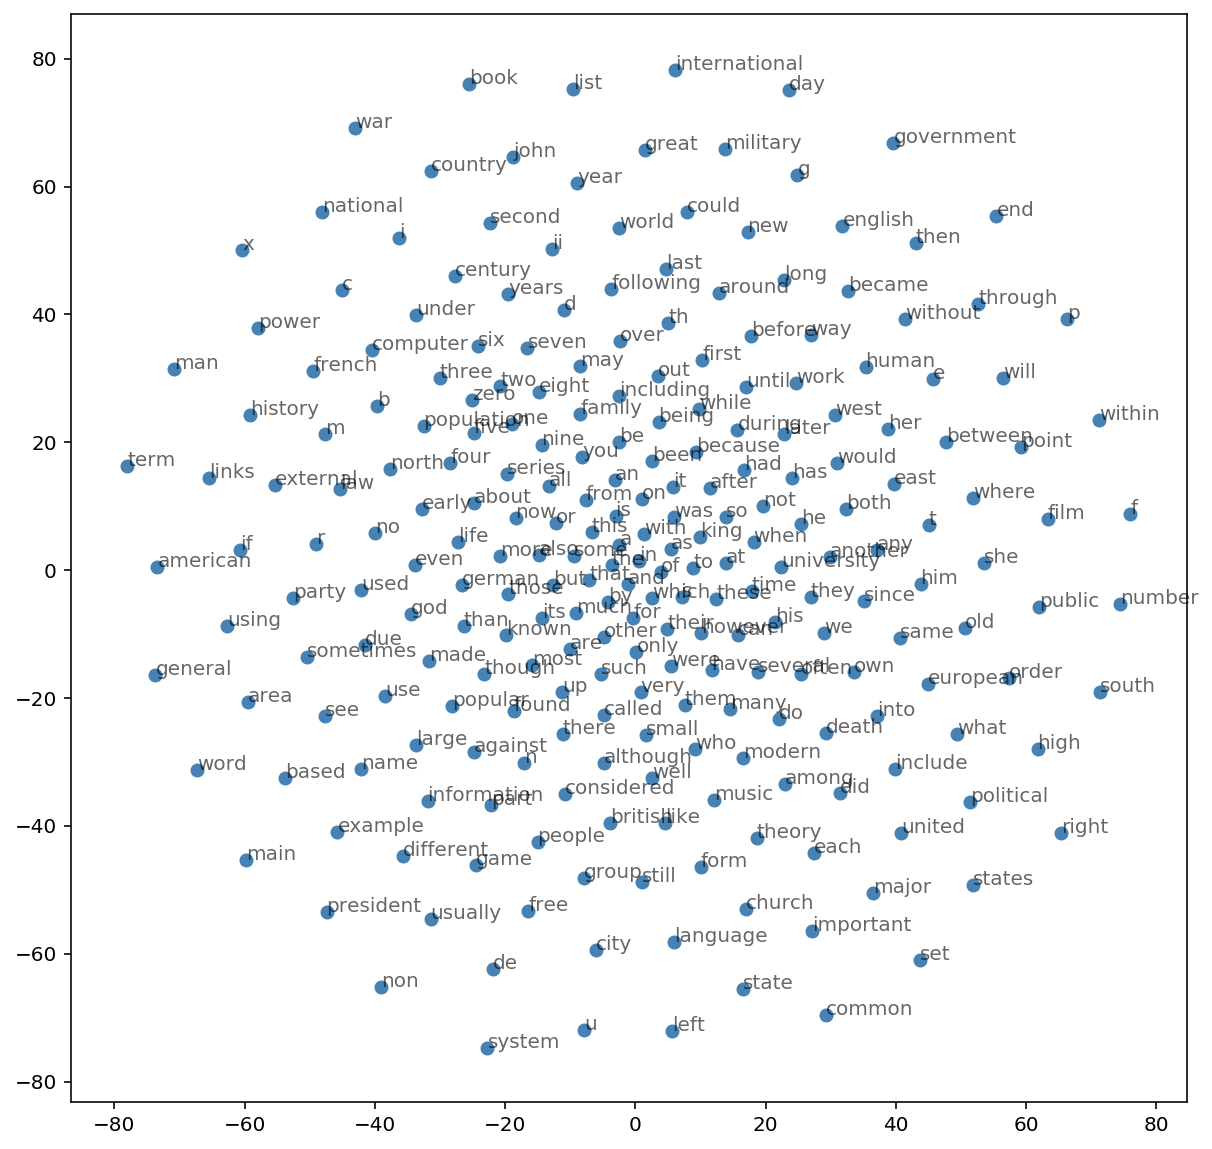

In [28]:
fig,ax = plt.subplots(figsize=(10,10))
for idx in range(word_graph):
    plt.scatter(*word_embedding_tsne[idx,:],color='steelblue')
    plt.annotate(rev_dictionary_[idx],(word_embedding_tsne[idx,0],word_embedding_tsne[idx,1]),alpha=0.6) 

In [29]:
with open(os.path.join('model_checkpoint','metainfo.tsv'),'w') as f:
    for i in range(len(rev_dictionary_)):
        f.write(rev_dictionary_[i] + '\n')

In [30]:
summary_writter = tf.summary.FileWriter('model_checkpoint',sess.graph)

config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
embedding_conf.metadata_path = os.path.join('model_checkpoint','metainfo.tsv')
projector.visualize_embeddings(summary_writter,config) 